In [6]:

import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
# from keras.utils import np_utils
from keras.utils import to_categorical

from tqdm import tqdm

## About the dataset¶
The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

* Each row is a separate image
* 785 columns
* First column = class_label (the target variable)
* Each column after represents one pixel value (784 total for a 28 x 28 image)

In [3]:
train_df = pd.read_csv("emnist-balanced-train.csv",header=None)

In [4]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.shape

(112800, 785)

We have 112800 rows (images), each described using 784 variables 28X28 pixels plus one column as output variable (the first column)

### Creating label dictionary¶
The output variables' values comprise of 0 to 46 values where 0-9 stands for 0-9 numbers, 10-35 stands for uppercase A-Z and 35+ stand for lowercase alphabets. We will thus create a dictionary which will have these as key and value pairs.

In [6]:
#Reading the file
label_map = pd.read_csv("mapping.txt",delimiter = ' ', header=None)
label_map.head()

,0,1
0,0,48
1,1,49
2,2,50
3,3,51
4,4,52


In [7]:
label_dictionary = {}

#Running a loop for ASCII equivalent to character conversion
for index, label in zip(label_map.iloc[:,0],label_map.iloc[:,1]):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [8]:
train_df_new = train_df[train_df[0].isin(np.arange(0, 36))]
train_df_new

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112795,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112796,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112797,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112798,31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_df_new[0].describe()

count    86400.000000
mean        17.500000
std         10.388355
min          0.000000
25%          8.750000
50%         17.500000
75%         26.250000
max         35.000000
Name: 0, dtype: float64

In [10]:
train_df_new.reset_index(inplace=True)
train_df_new

,index,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,3,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,32,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,112795,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86396,112796,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86397,112797,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86398,112798,31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
x_train = train_df_new.loc[:, 1:]
y_train = train_df_new.loc[:, 0]

x_train.shape, y_train.shape

((86400, 784), (86400,))

## Visualising Sample Data

In [12]:
sample_image = x_train.iloc[1255]
sample_label = y_train.iloc[1255]
sample_image.shape, sample_label

((784,), 5)

Label entry No. 1255: 5


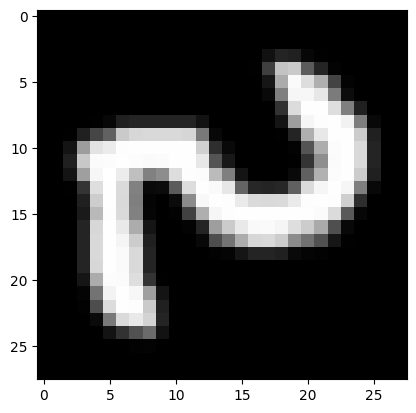

In [13]:
W = 28
H = 28

print("Label entry No. 1255:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(W, H), cmap=plt.cm.gray)
plt.show()

In [14]:
def flip_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [15]:
x_train = np.apply_along_axis(flip_and_rotate, 1, x_train.values)
x_train.shape

(86400, 28, 28)

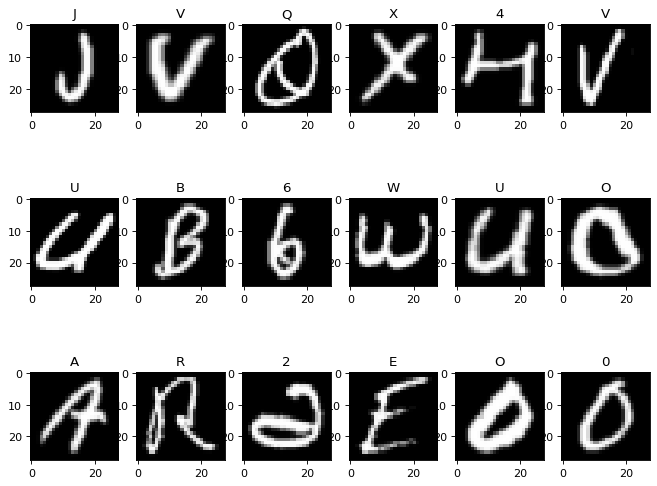

In [16]:
plt.figure(figsize=(10, 8), dpi=80)
for i in range(100, 118):
    plt.subplot(3,6,i-99)
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_train[i]])

In [17]:
x_train.shape

(86400, 28, 28)

In [18]:
x_train = x_train.astype('float32') / 255
x_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00784314, 0.03529412, 0.1254902 ,
        0.01176471, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.1333

### One Hot Encoding of the Output Labels¶
As the output values are integers, from 0 to 35, we must perform one hot encoding so as to get a number of output columns comprised of 0 and 1 class labels.

In [19]:
#Finding the number of output columns
number_of_classes = y_train.nunique()
number_of_classes

36

In [20]:
#One hot encoding of numpy array
y_train = to_categorical(y_train, number_of_classes)
y_train.shape

(86400, 36)

In [21]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

### Reshaping the train data¶
As tensorflow requires 4D Array, (batch X width X height X channel) and our x_train is 3D array (no. of images X width X height), we will be adding one more dimension to the x_train

In [22]:
x_train.shape

(86400, 28, 28)

In [23]:
x_train = x_train.reshape(-1, W, H, 1)
x_train.shape

(86400, 28, 28, 1)

In [24]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size= 0.1, 
                                                  random_state=88)

## Model Building

In [25]:
model = Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(W, H, 1)))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(number_of_classes, activation='softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 48)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 256)              

In [26]:
# Optimizing Algorithm for Backpropagation

optimizer_name = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint('my_model.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

In [27]:

history = model.fit(x_train,
                    y_train, 
                    epochs=5,
                    validation_data=(x_val,y_val),
                    batch_size=32, 
                    verbose=1, 
                    callbacks=[early_stopping, mcp_save])

Epoch 1/5


2428/2430 [============================>.] - ETA: 0s - loss: 0.5031 - accuracy: 0.8314
Epoch 1: val_loss improved from inf to 0.31684, saving model to my_model.h5
2430/2430 [==============================] - 27s 11ms/step - loss: 0.5030 - accuracy: 0.8314 - val_loss: 0.3168 - val_accuracy: 0.8811
Epoch 2/5
  10/2430 [..............................] - ETA: 27s - loss: 0.3087 - accuracy: 0.8938

c:\Users\tilak\anaconda3\envs\MRS\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2426/2430 [============================>.] - ETA: 0s - loss: 0.2741 - accuracy: 0.8961
Epoch 2: val_loss improved from 0.31684 to 0.26600, saving model to my_model.h5
2430/2430 [==============================] - 26s 11ms/step - loss: 0.2741 - accuracy: 0.8961 - val_loss: 0.2660 - val_accuracy: 0.9034
Epoch 3/5
2425/2430 [============================>.] - ETA: 0s - loss: 0.2318 - accuracy: 0.9105
Epoch 3: val_loss did not improve from 0.26600
2430/2430 [==============================] - 27s 11ms/step - loss: 0.2318 - accuracy: 0.9105 - val_loss: 0.2832 - val_accuracy: 0.8987
Epoch 4/5
2430/2430 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9181
Epoch 4: val_loss improved from 0.26600 to 0.26430, saving model to my_model.h5
2430/2430 [==============================] - 26s 11ms/step - loss: 0.2037 - accuracy: 0.9181 - val_loss: 0.2643 - val_accuracy: 0.9007
Epoch 5/5
2429/2430 [============================>.] - ETA: 0s - loss: 0.1816 - accuracy: 0.9253
Epoch 5: v

## Plotting Accuracy

In [28]:
def plotgraph(epochs, acc, val_acc,txt):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title(txt)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

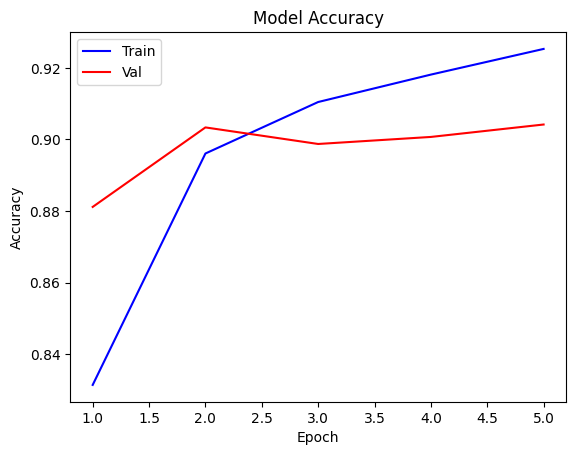

In [29]:
# Accuracy curve
plotgraph(epochs, acc, val_acc,"Model Accuracy")

Loss Curve


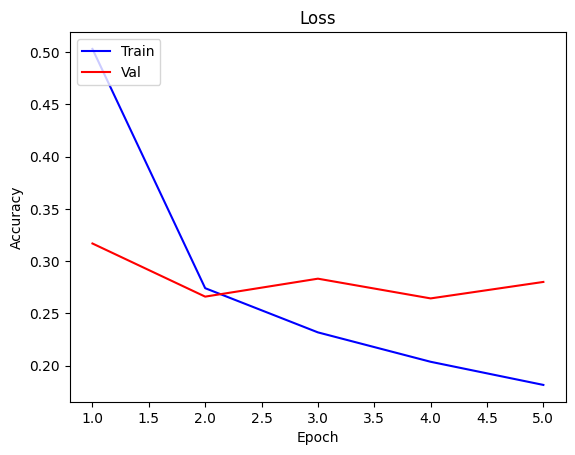

In [30]:
print('Loss Curve')
plotgraph(epochs, loss, val_loss,"Loss")

In [7]:
# Load best model
model = load_model('my_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 48)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 256)               3

In [ ]:
y_pred = model.predict(x_val)
y_pred.shape

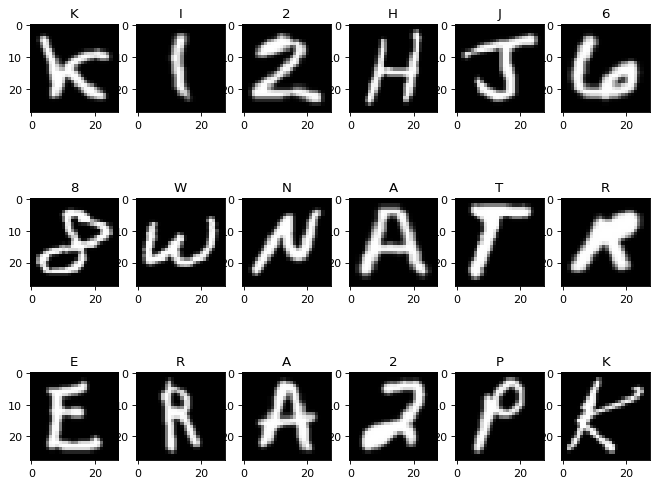

In [33]:
plt.figure(figsize=(10, 8), dpi=80)
for i in range(200, 218):
    plt.subplot(3,6,i-199)
    plt.imshow(x_val[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_pred[i].argmax()])

In [34]:
val_acc = model.evaluate(x_val, y_val)
print('Loss value is ',val_acc[0])
print('Accuracy value is ',val_acc[1])

270/270 [==============================] - 7s 26ms/step - loss: 0.2643 - accuracy: 0.9007
Loss value is  0.2643047273159027
Accuracy value is  0.9006944298744202


In [77]:
#Loading the dataset
test_df = pd.read_csv('emnist-balanced-test.csv', header=None)
test_df.shape

(18800, 785)

In [78]:
test_df_new = test_df[test_df[0].isin(np.arange(0, 36))]
test_df_new.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,14400.000000,14400.0,14400.0,14400.0,14400.0,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,...,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0,14400.0
mean,17.500000,0.0,0.0,0.0,0.0,0.007917,0.025764,0.014722,0.012222,0.014722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,10.388655,0.0,0.0,0.0,0.0,0.604236,2.012452,1.204803,1.019562,1.733652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,8.750000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,17.500000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,26.250000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,35.000000,0.0,0.0,0.0,0.0,63.000000,213.000000,108.000000,95.000000,208.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
test_df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
x_test = test_df_new.loc[:, 1:]
y_test = test_df_new.loc[:, 0]

x_test.shape, y_test.shape

((14400, 784), (14400,))

In [83]:
x_test = np.apply_along_axis(flip_and_rotate, 1, x_test.values)
y_test = to_categorical(y_test, number_of_classes)

x_test.shape, y_test.shape

((14400, 28, 28), (14400, 36))

In [84]:
#Normalisation
x_test = x_test.astype('float32') / 255

In [85]:
x_test = x_test.reshape(-1, W, H, 1)
x_test.shape

(14400, 28, 28, 1)

In [86]:
test_acc = model.evaluate(x_test, y_test)
print('Loss value is ',test_acc[0])
print('Accuracy value is ',test_acc[1])

450/450 [==============================] - 1s 2ms/step - loss: 0.2514 - accuracy: 0.9065
Loss value is  0.25144901871681213
Accuracy value is  0.9065277576446533


In [87]:
#Prediction
y_pred_test = model.predict(x_test)
# Finding shape
y_pred_test.shape

450/450 [==============================] - 1s 2ms/step


(14400, 36)

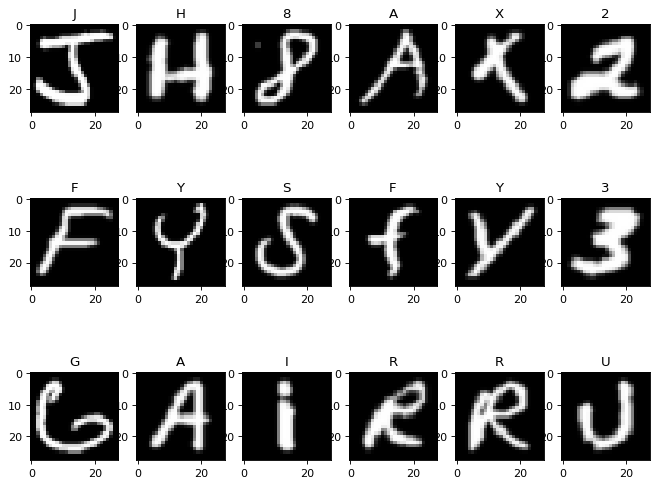

In [88]:

plt.figure(figsize=(10, 8), dpi=80)
for i in range(200, 218):
    plt.subplot(3,6,i-199)
    plt.imshow(x_test[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_pred_test[i].argmax()])

In [ ]:
plt.imshow(gray_reshaped[0], cmap=plt.cm.gray)

In [ ]:
#Prediction
y_pred_test1 = model.predict(gray_reshaped)
# Finding shape
y_pred_test1.shape

In [ ]:
label_dictionary[y_pred_test1.argmax()]

In [90]:
plt.figure(figsize=(10, 8), dpi=80)
plt.imshow(gray_reshaped[0], cmap=plt.cm.gray)
plt.title(label_dictionary[y_pred_test1[0].argmax()])

NameError: name 'gray_reshaped' is not defined

<Figure size 800x640 with 0 Axes>